### TIme Series Econometrics
Alexander Skorobogatov

# Topic 2. VAR-SVAR: theory and simulations

### I.
VAR(1) is given by:
$$x_{t} = a_{11} x_{t-1} + a_{12} y_{t-1} + u_t$$ 
$$y_{t} = a_{21} x_{t-1} + a_{22} y_{t-1} + v_t$$  
or in matrix form
$$x_{t} = A x_{t-1} + \epsilon_{t}$$
where $\epsilon_{t}$ ~ $N(0,\Sigma)$

1. Create a matrix A of a stable system (absolute eigenvalues of $A$ should be less than unity)  
2. Simulate a dataset in line with A (calculate the eigenvalues)  
3. Calculate the reverse polynomial
4. Visualize the system  
5. Estimate VAR model and report the results
6. Report irfs
7. Calculate irfs manually to check the way it is done by the program

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 1,2
A = np.random.uniform(-0.5,0.5,(2,2))
print(A)
np.linalg.eig(A)[0]

[[ 0.10470349 -0.15689113]
 [-0.32882472  0.27158583]]


array([-0.05383077,  0.4301201 ])

In [3]:
# 3
a,b,c = (A[0,0]*A[1,1] - A[0,1]*A[1,0]),-(A[0,0]+A[1,1]),1
d = (-b)**2 - 4*(a*c)
r1 = (-b + np.sqrt(d))/(2*a)
r2 = (-b - np.sqrt(d))/(2*a)
print(d)
print(r1)
print(r2)

0.2342084477292307
-18.57673507606026
2.3249320324109624


### 3. Reverse characteristic polynomial a different way

In [4]:
from sympy import *

In [5]:
# Reproduce the example from Lutkepohl p. 17
I = Identity(3)
X1 = MatrixSymbol('X', 3, 3)
z = symbols('z')
a = np.array([[0.5,0,0],[0.1,0.1,0.3],[0,0.2,0.3]])
AA = Matrix(a)
X2 = Matrix(I - X1@z)
X3 = X2.subs(X1,AA)
X4 = X3.det()
solve(Eq(X4,0),z)

[-15.4858377035486, 2.00000000000000, 2.15250437021530]

In [6]:
AA

Matrix([
[0.5,   0,   0],
[0.1, 0.1, 0.3],
[  0, 0.2, 0.3]])

In [7]:
X3

Matrix([
[1 - 0.5*z,         0,         0],
[   -0.1*z, 1 - 0.1*z,    -0.3*z],
[        0,    -0.2*z, 1 - 0.3*z]])

In [8]:
X4

0.015*z**3 + 0.17*z**2 - 0.9*z + 1

In [9]:
# Or from my example here
I = Identity(2)
X1 = MatrixSymbol('X', 2, 2)
z = symbols('z')
AA = Matrix(A)
X2 = Matrix(I - X1@z)
X3 = X2.subs(X1,AA)
X4 = X3.det()
solve(Eq(X4,0),z)

[-18.5767350760602, 2.32493203241096]

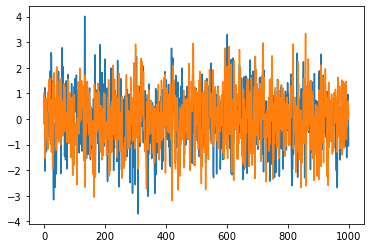

In [10]:
# 4
T = 1000
mean = [0, 0]
cov = [[1, 0.5], [0.5, 1]] 
e1,e2 = np.random.multivariate_normal(mean, cov, T).T
y = []
z = []
y.append(1)
z.append(1)
for t in range(1,T):
    a = A[0,0]*y[t-1] + A[0,1]*z[t-1] + e1[t]
    b = A[1,0]*y[t-1] + A[1,1]*z[t-1] + e2[t]
    y.append(a)
    z.append(b)
plt.plot(y, label = "line 1")
plt.plot(z, label = "line 2")

In [11]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, SVAR

In [12]:
# 5
data = np.array([y,z]).T
model = VAR(data)
res = model.fit(1)
print(res.coefs)
print(A)

[[[ 0.13568591 -0.19170625]
  [-0.3384763   0.28508082]]]
[[ 0.10470349 -0.15689113]
 [-0.32882472  0.27158583]]


In [13]:
# 6
print(res.irf(2).irfs) # program
print(f"\n Manually t+1 is \n{res.coefs@np.eye(2)}") # manually t+1
print(f"Manually t+2 is \n{np.linalg.matrix_power(res.coefs,2)@np.eye(2)}") # manually t+2

[[[ 1.          0.        ]
  [ 0.          1.        ]]

 [[ 0.13568591 -0.19170625]
  [-0.3384763   0.28508082]]

 [[ 0.08329869 -0.08066361]
  [-0.14241957  0.1461591 ]]]

 Manually t+1 is 
[[[ 0.13568591 -0.19170625]
  [-0.3384763   0.28508082]]]
Manually t+2 is 
[[[ 0.08329869 -0.08066361]
  [-0.14241957  0.1461591 ]]]


### VAR: from structural to reduced and back
1. Create structural and reduced form dataset without the error to check that the resultant series are the same
2. Compare numbers and plots
3. Create a dataset with zero error covariance
4. Compare A, AA, and coefs
5. Compare B and res.A; calculate res.A manually
6. Calculate res.B manually

### Some theory
$$A x_{t} = A_{1} x_{t-1} + B \epsilon_{t}$$  
$$x_{t} = A^{-1}(A_{1} x_{t-1} + B \epsilon_{t})$$  

Data makes possible the estimation of $A^{-1}A_{1}$. The next task is to distinguish between $A$ and $A_{1}$. This is possible if we take into account:
1. Diagonal entries of A are unities
2. Economic logic at hand suggesting causation between x and y, so that $A = \left[
 \begin{matrix}
   1 & a_{10} \\
   0 &  1
  \end{matrix} 
\right]$

In the above example we assume $x_{2}$ instantaneously causes $x_{1}$ but not vice versa. Given these assumptions, $a_{10}$ can be restored from an estimate of $A^{-1}A_{1}$ and its variance-covariance matrix.

### Three types of models
A-model: restrictions are placed on A, while B is set to identity matrix  
B-model: restrictions are placed on B, while A is set to identity matrix  
AB-model: restrictions are placed on both matrices

#### Restore A from coef. estimates  
This reduces to finding the only unknown entry in A, which is done as follows
$$a_{10} = -cov(e_{1},e_{1})/var(x_{2})$$

#### Restore B from coef. estimates  
This is done using the relationaship between resid. vcov and A
$$\Sigma_{r} = A^{-1} B B^{T} A^{-1^{T}}$$
so that B is restored as follows
$$B = chol(A \Sigma_{r} A^{T})$$
where chol is Cholesky decomposition.

In [14]:
# 1
A = np.random.uniform(-0.5,0.5,(2,2))
print(A)
a10 = -1.1
B = np.eye(2)
B[0,1] = -a10
print(B)
AA = np.linalg.inv(B)@A
print(AA)
T = 100
y1 = []
z1 = []
#y1.append(0)
#z1.append(0)
y1.append(1)
z1.append(1)
for t in range(1,T+1):
    b = A[1,0]*y1[t-1] + A[1,1]*z1[t-1]
    z1.append(b)
    a = A[0,0]*y1[t-1] + A[0,1]*z1[t-1] + a10*z1[t]
    y1.append(a)

y2 = []
z2 = []   
#y2.append(0)
#z2.append(0)
y2.append(1)
z2.append(1)
for t in range(1,T+1):
    a = AA[0,0]*y2[t-1] + AA[0,1]*z2[t-1]
    b = AA[1,0]*y2[t-1] + AA[1,1]*z2[t-1]
    y2.append(a)
    z2.append(b)
    
print(y1[:6])
print(z1[:6])
print(y2[:6])
print(z2[:6])

[[ 0.33696707  0.33525292]
 [-0.24900312  0.06371466]]
[[1.  1.1]
 [0.  1. ]]
[[ 0.6108705   0.2651668 ]
 [-0.24900312  0.06371466]]
[1, 0.8760372927315658, 0.48601299064002446, 0.2359181183634482, 0.10814039816593565, 0.04819059249892414]
[1, -0.18528845592131737, -0.22994160662633942, -0.1356694004024308, -0.06738847632953278, -0.03122092997440569]
[1, 0.8760372927315658, 0.4860129906400244, 0.23591811836344817, 0.10814039816593563, 0.04819059249892412]
[1, -0.18528845592131737, -0.22994160662633942, -0.13566940040243078, -0.06738847632953276, -0.031220929974405683]


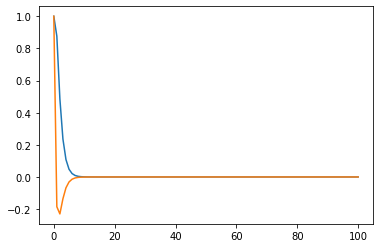

In [15]:
# 2
plt.plot(y1, label = "line 1")
plt.plot(z1, label = "line 2")

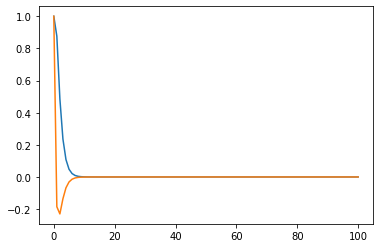

In [16]:
plt.plot(y2, label = "line 1")
plt.plot(z2, label = "line 2")

[[ 0.32661553  0.35490296]
 [ 0.16239237 -0.05656047]]
[[1.  0.6]
 [0.  1. ]]
[[ 0.2291801   0.38883924]
 [ 0.16239237 -0.05656047]]


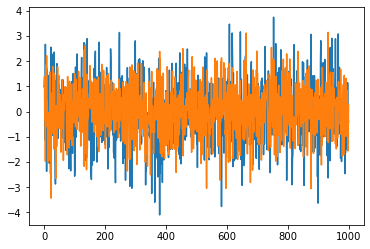

In [17]:
# 3
A = np.random.uniform(-0.5,0.5,(2,2))
print(A)
a10 = -0.6
B = np.eye(2)
B[0,1] = -a10
print(B)
AA = np.linalg.inv(B)@A
print(AA)
T = 1000
mean = [0, 0]
cov = [[1, 0], [0, 1]] 
e1,e2 = np.random.multivariate_normal(mean, cov, T).T
y1 = []
z1 = []
#y1.append(0)
#z1.append(0)
y1.append(1)
z1.append(1)
for t in range(1,T):
    b = A[1,0]*y1[t-1] + A[1,1]*z1[t-1] + e1[t]
    z1.append(b)
    a = A[0,0]*y1[t-1] + A[0,1]*z1[t-1] + a10*z1[t] + e2[t]
    y1.append(a)
plt.plot(y1, label = "line 1")
plt.plot(z1, label = "line 2")

In [18]:
# SVAR Estimates

# Matrices A B
A2 = np.asarray([[1,'E'],[0,1]])
B2 = np.asarray([['E',0],[0,'E']])

# Model and results
data = np.array([y1,z1]).T
mymodel = SVAR(data, svar_type='AB', A=A2, B=B2, missing='drop')
res = mymodel.fit(maxiter=10000, maxfun=10000)

In [19]:
res.k_exog_user = 0
res.summary()

  Summary of Regression Results   
Model:                        SVAR
Method:                        OLS
Date:           Sun, 11, Dec, 2022
Time:                     15:22:45
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                 -0.0386676
Nobs:                     999.000    HQIC:                -0.0569364
Log likelihood:          -2795.00    FPE:                   0.934132
AIC:                   -0.0681375    Det(Omega_mle):        0.928547
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.051237         0.036284           -1.412           0.158
L1.y1         0.192395         0.033616            5.723           0.000
L1.y2         0.387830         0.040927            9.476           0.000

Results for equation 

In [86]:
# 4
print('coefs',res.coefs,sep='\n')
print('simul.coefs',A,sep='\n')
print('simul.reduced_coefs',AA,sep='\n')

coefs
[[[ 0.19239455  0.38782954]
  [ 0.18503557 -0.02831156]]]
simul.coefs
[[ 0.32661553  0.35490296]
 [ 0.16239237 -0.05656047]]
simul.reduced_coefs
[[ 0.80760545 -0.38782954]
 [-0.18503557  1.02831156]]


In [96]:
# 5
cov = np.cov(res.resid[:,0],res.resid[:,1]) # compute resid. vcov

print('a10 calculated manually',cov[1][0]/cov[1][1],sep='\n')
print('a10 from the output',res.A,sep='\n')
print('a10 simul. value',B,sep='\n')

a10 calculated manually
-0.5687045553334614
a10 from the output
[[1.         0.56870454]
 [0.         1.        ]]
a10 simul. value
[[1.  0.6]
 [0.  1. ]]


In [112]:
# 6
BB = np.linalg.cholesky(res.A@cov@res.A.T)

print('res.B calculated manually',np.round(BB,3),sep='\n')
print('res.B from the output',res.B,sep='\n')

res.B calculated manually
[[ 1.008  0.   ]
 [-0.     0.954]]
res.B from the output
[[1.00865446 0.        ]
 [0.         0.95534329]]


### Calculate irfs from SVAR manually
1. Report irfs  
2. Calculate manually 

$$Irf_{1} = A^{-1} V(e)$$

$$Irf_{n} = coef^{n-1} Irf_{1}$$

In [116]:
# 1.
res.irf(3).svar_irfs

array([[[ 1.00865446, -0.54330806],
        [ 0.        ,  0.95534329]],

       [[ 0.19405962,  0.26598083],
        [ 0.18663695, -0.12757857]],

       [[ 0.10971934,  0.00169452],
        [ 0.03062395,  0.05282786]],

       [[ 0.03298627,  0.02081422],
        [ 0.01943497, -0.00118209]]])

In [117]:
# 2
irf1 = np.linalg.inv(res.A)@res.B # for t
irf1

array([[ 1.00865446, -0.54330806],
       [ 0.        ,  0.95534329]])

In [118]:
# then use coefs
print(res.coefs@irf1) # t+1
print(np.linalg.matrix_power(res.coefs,2)@irf1) # t+2
print(np.linalg.matrix_power(res.coefs,3)@irf1) # t+3

[[[ 0.19405962  0.26598083]
  [ 0.18663695 -0.12757857]]]
[[[0.10971934 0.00169452]
  [0.03062395 0.05282786]]]
[[[ 0.03298627  0.02081422]
  [ 0.01943497 -0.00118209]]]
